### 1. The model used to predict the noise from a sample: a UNet

In [1]:
from diffusers import UNet2DConditionModel

unet_model = UNet2DConditionModel(
    sample_size=32,
    in_channels=3,
    out_channels=3,
    down_block_types=(
        "DownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
    ),
    up_block_types=(
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "UpBlock2D",
    ),
    block_out_channels=(64, 128, 256),
    cross_attention_dim=512
)

c:\Users\enoch\.conda\envs\deeplearn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\enoch\.conda\envs\deeplearn\Lib\site-packages\xformers\__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # noqa
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\enoch\.conda\envs\deeplearn\Lib\site-packages\xformers\triton\softmax.py", line 11, in <module>
    import triton
ModuleNotFoundError: No module named 'triton'


In [2]:
# test forward pass
import torch

x = torch.randn(1, 3, 32, 32)
t = torch.randint(0, 1000, (1, ))
y = torch.randn(1, 150, 512)

out = unet_model(x, t, y)
out.sample.shape

torch.Size([1, 3, 32, 32])

In [3]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="squaredcos_cap_v2",
)


loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

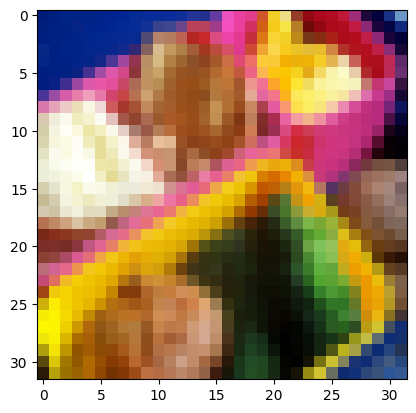

In [4]:
import matplotlib.pyplot as plt
from torchvision.datasets import CocoCaptions
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

dataset = CocoCaptions(
    root="C:/Datasets/coco2017/train2017",
    annFile="C:/Datasets/coco2017/annotations/captions_train2017.json",
    transform=transform,
)

test_img, labels = dataset[0]
test_img = test_img * 0.5 + 0.5
plt.imshow(test_img.permute(1, 2, 0))
labels

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
from transformers import CLIPModel, CLIPTokenizerFast

tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").text_model.requires_grad_(False).to(device)

def encode_text(text):
    with torch.no_grad():
        return model(tokenizer(text, return_tensors="pt").input_ids.to(device)).last_hidden_state
    
def encode_text_batch(texts):
    with torch.no_grad():
        return model(tokenizer(texts, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)).last_hidden_state

In [7]:
encode_text("a photo of a cat")

tensor([[[ 0.3393,  0.1165,  0.1020,  ...,  0.2468,  0.5906,  0.1013],
         [ 1.9753, -0.5844,  0.3685,  ...,  1.1658,  0.8050, -0.9801],
         [ 1.0580, -0.9600,  1.0018,  ..., -0.5155, -0.1437, -1.9444],
         ...,
         [ 0.3059, -1.5037, -0.4022,  ..., -0.0224,  0.9105, -0.3916],
         [ 1.0118, -0.6701,  1.7742,  ..., -0.1556, -0.0250, -1.5062],
         [-0.5152,  0.1658,  0.8876,  ..., -0.0675, -0.4551, -1.7960]]],
       device='cuda:0')

loading annotations into memory...
Done (t=0.43s)
creating index...
index created!


'A bunch of trays that have different food.'

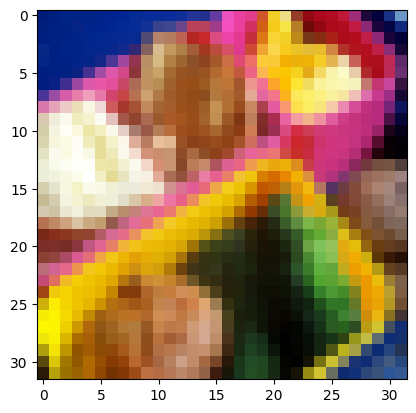

In [8]:
from random import choice

class SigmaDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = CocoCaptions(
            root="C:/Datasets/coco2017/train2017",
            annFile="C:/Datasets/coco2017/annotations/captions_train2017.json",
            transform=transform,
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, text_labels = self.dataset[idx]
        random_text = choice(text_labels)
        return img, random_text
    
sigma_dataset = SigmaDataset(dataset)
test_img, text = sigma_dataset[0]
test_img = test_img * 0.5 + 0.5
plt.imshow(test_img.permute(1, 2, 0))
text

Test noising the image using the diffusers scheduler

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42025468..1.5164828].


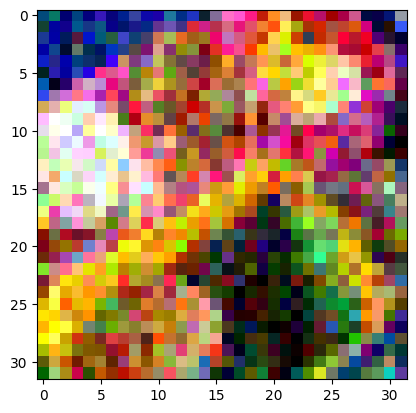

In [9]:
noise = torch.randn(1, 3, 32, 32)
timesteps = torch.LongTensor([100])
noised = scheduler.add_noise(test_img, noise, timesteps)
plt.imshow(noised[0].permute(1, 2, 0))

In [10]:
SigmaLoader = DataLoader(sigma_dataset, batch_size=32, shuffle=True)

batch = next(iter(SigmaLoader))
imgs, texts = batch
print(imgs.shape, texts)
text_embeddings = encode_text_batch(texts)
text_embeddings.shape

torch.Size([32, 3, 32, 32]) ('Four men playing a game of couples tennis.', 'Many colorful things are flying high up in the air. ', 'A street scene with an electric bus going by.', 'A living room filled with lots of clutter and boxes.', 'A corned beef sandwich with some french fries.', 'A person uses a knife to cut a pizza on a stove.', 'a building that has some machines in it', 'Dog and a ram sheep staring at each other.', 'A black and white photograph of a woman taking care of a child on a park bench.', 'A toilet and a urinal with male and female signs.', 'A family of giraffes standing next to a pile of logs.', 'a body of water with some umbrellas coming out of it ', 'A old picture of workers building the railroad.', 'a man holds a rope while getting pulled by a boat', 'A view of birds gliding through the air.', 'Two pieces of black luggage rest against the rails of a staircase.', 'a cheese pizza cut into many slices on a table', 'The food on the table is ready to be eaten. ', 'A man 

torch.Size([32, 25, 512])

In [11]:
from tqdm import tqdm
from torch import optim

unet_model = UNet2DConditionModel(
    sample_size=32,
    in_channels=3,
    out_channels=3,
    down_block_types=(
        "DownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
    ),
    up_block_types=(
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "UpBlock2D",
    ),
    block_out_channels=(64, 128, 256),
    cross_attention_dim=512
).to(device)
SigmaLoader = DataLoader(sigma_dataset, batch_size=64, shuffle=True)
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()
NUM_EPOCHS = 20

In [12]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}", end=" ")
    pbar = tqdm(SigmaLoader, total=len(SigmaLoader), leave=True)

    for imgs, texts in pbar:
        imgs = imgs.to(device)
        texts = encode_text_batch(texts).to(device)
        noise = torch.randn(imgs.shape).to(device)
        timesteps = torch.randint(0, 1000, (imgs.shape[0], )).to(device)
        noised = scheduler.add_noise(imgs, noise, timesteps)
        optimizer.zero_grad()
        out = unet_model(noised, timesteps, texts)
        loss = loss_fn(out.sample, noise)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

Epoch 1/20 

  0%|          | 0/1849 [00:00<?, ?it/s]c:\Users\enoch\.conda\envs\deeplearn\Lib\site-packages\diffusers\models\attention_processor.py:1476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(
 78%|███████▊  | 1449/1849 [09:33<02:38,  2.53it/s, loss=0.0656]


KeyboardInterrupt: 

In [13]:
torch.save(unet_model.state_dict(), "unet_model.pt")

In [21]:
# Inference code

@torch.no_grad()
def model_sample(model, text, scheduler):
    model.eval()
    text_embedding = encode_text(text).to(device)
    sample = torch.randn(1, 3, 32, 32).to(device)

    for t in tqdm(range(999, -1, -1)):
        out = model(sample, torch.LongTensor([t]).to(device), text_embedding).sample
        out = scheduler.step(out, t, sample)
        sample = out.prev_sample
        pred_t_0 = out.pred_original_sample

    return sample


sample = model_sample(unet_model, "a photo of a cat", scheduler)

100%|██████████| 1000/1000 [00:19<00:00, 51.13it/s]


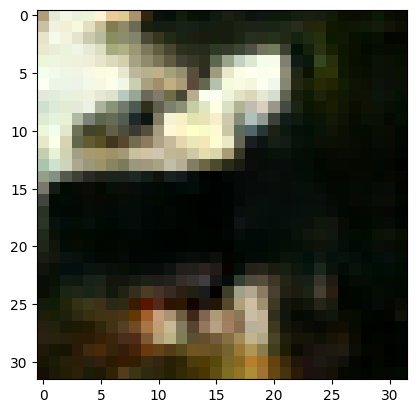

In [22]:

plt.imshow((sample[0]* 0.5 + 0.5).cpu().permute(1, 2, 0))